In [638]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn import linear_model


from scipy import stats

from sklearn.metrics import confusion_matrix

import pylab

import math

def imagesc(x):
    plt.imshow(x,extent = [0,1,0,1])

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [639]:
# setting parameters we know about the data in advance

srate = 2048

# electrode stips information for plotting

stripborders = [[0,5],[6,11],[12,17],[18,21],[22,27],[28,35],[36,41],[41,47],[48,51]]
striplabels = ['Left Frontal 1','Left Frontal 2','Left Frontal 3','Left Motor', \
              'Right Frontal 1','Right Frontal 2','Right Frontal 3','Right Frontal 4','Right Motor']

strips = [list(range(stripborders[i][0],stripborders[i][1]+1)) for i in range(len(stripborders))]
strips

[[0, 1, 2, 3, 4, 5],
 [6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17],
 [18, 19, 20, 21],
 [22, 23, 24, 25, 26, 27],
 [28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41],
 [41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51]]

In [640]:
# load trials data
name_prefix = 'pol_van_co_16_left_step4herz' # to save figures

matfile_path ='co_van_16_left_step4herz.mat'
matfile = loadmat(matfile_path)

ecog_trials = matfile['ecog_trials']
feat_trials = matfile['feat_trials']
posX_trials = matfile['posX_trials']
posY_trials = matfile['posY_trials']
par_trials = matfile['par_trials'][0]

del matfile

In [641]:
# choose features that will be analyzed

numch_ecog = ecog_trials[0].shape[1]
fbandmins_len = feat_trials[0].shape[1]//numch_ecog

ch_idxs_motor = [18,19,20,21,48,49,50,51]
#ch_idxs_cihosen = [0]
ch_idxs_chosen = range(numch_ecog) #ch_idxs_motor #[ch_idxs_motor[0]]

ch_idxs_all_chosen = []

for c in ch_idxs_chosen:
    feat_idxs_all = [c + numch_ecog*i for i in range(fbandmins_len)]
    for f in feat_idxs_all:
        ch_idxs_all_chosen.append(f)
        
ch_idxs_all_chosen.sort()
#ch_idxs_all_motor = ch_idxs_all_motor[-16:]

#print(ch_idxs_all_chosen)

In [620]:
# define moments in time that will be analyzed

step_div = 32

num_w = int(2.5*step_div)

win_starts = np.arange(0,num_w)*srate//step_div
print(win_starts)

win_ends = win_starts + srate//4
print(win_ends)

[   0   64  128  192  256  320  384  448  512  576  640  704  768  832
  896  960 1024 1088 1152 1216 1280 1344 1408 1472 1536 1600 1664 1728
 1792 1856 1920 1984 2048 2112 2176 2240 2304 2368 2432 2496 2560 2624
 2688 2752 2816 2880 2944 3008 3072 3136 3200 3264 3328 3392 3456 3520
 3584 3648 3712 3776 3840 3904 3968 4032 4096 4160 4224 4288 4352 4416
 4480 4544 4608 4672 4736 4800 4864 4928 4992 5056]
[ 512  576  640  704  768  832  896  960 1024 1088 1152 1216 1280 1344
 1408 1472 1536 1600 1664 1728 1792 1856 1920 1984 2048 2112 2176 2240
 2304 2368 2432 2496 2560 2624 2688 2752 2816 2880 2944 3008 3072 3136
 3200 3264 3328 3392 3456 3520 3584 3648 3712 3776 3840 3904 3968 4032
 4096 4160 4224 4288 4352 4416 4480 4544 4608 4672 4736 4800 4864 4928
 4992 5056 5120 5184 5248 5312 5376 5440 5504 5568]


In [622]:
# convert trial parameters (position on circle) to angles
par_trials_rad = (math.pi/4)*par_trials
par_trials_rad_sc = np.column_stack([np.sin(par_trials_rad), np.cos(par_trials_rad)])
par_trials_sin = par_trials_rad_sc[:,0]
par_trials_cos = par_trials_rad_sc[:,1]

par_trials_rad_sc_tile = np.tile(par_trials_rad_sc,[512,1]).T.reshape([-1])

In [624]:
# plant a fake feature encoding angle to test code below
#for tr in range(40):
#    feat_trials[tr][0:srate,17] = np.array([par_trials_sin[tr]]*srate)

In [635]:
# find features that correlate with trial parameter (angle)

numch_feat = feat_trials.shape[-1] 
res_ch_w = np.zeros([len(ch_idxs_all_chosen),num_w])

chnum = 0

par_trials_rad_sc_tile = np.tile(par_trials_rad_sc,[512,1]).T.reshape([-1])

for ch in ch_idxs_all_chosen:

    #print('channel ', ch)

    for w in range(len(win_starts)):

        feat_trials_red = [feat_trials[i][win_starts[w],ch].T for i in range(len(feat_trials))]
        feat_trials_red = np.array(feat_trials_red)
        #feat_trials_red = [feat_trials[i][win_ends[w],ch].T - \
        #                feat_trials[i][win_starts[w],ch].T for i in range(len(feat_trials))]
        

        '''
        numit = 100
    
        res_true = []
        res_pred = []

        for it in range(numit):
            X_train, X_test, y_train, y_test = train_test_split(feat_trials_red, par_trials_sin, test_size=0.2)

            svr = SVR(kernel='rbf', C=1e2, gamma=0.1)

            pred = svr.fit(X_train, y_train).predict(X_test)

            res_pred.append(pred)
            res_true.append(y_test)

        res_pred_flat = np.array(res_pred).reshape(-1)
        res_true_flat = np.array(res_true).reshape(-1)
        '''
        
        #print(feat_trials_red.shape)
        #print(par_trials_sin.shape)

        slope, intercept, r_value_1, p_value, std_err = stats.linregress(feat_trials_red, par_trials_sin)
        slope, intercept, r_value_2, p_value, std_err = stats.linregress(feat_trials_red, par_trials_cos)
        
        #r2 = r2_score(res_true_flat, res_pred_flat)
        
        r2 = r_value_1**2 #(r_value_1**2 + r_value_2**2)/2    #r_value_1**2 #/(1 - r_value_1**2)
        
        
        #print("r-squared:", round(r2,2))
        res_ch_w[chnum,w] = r2
        
        
        #print(res_true_flat)
        #print(res_pred_flat)

    chnum = chnum + 1
    
    

In [636]:
res_ch_w_re = res_ch_w.reshape([len(ch_idxs_chosen),fbandmins_len,num_w],order='F')

res_ch_w_re.shape

(52, 20, 80)

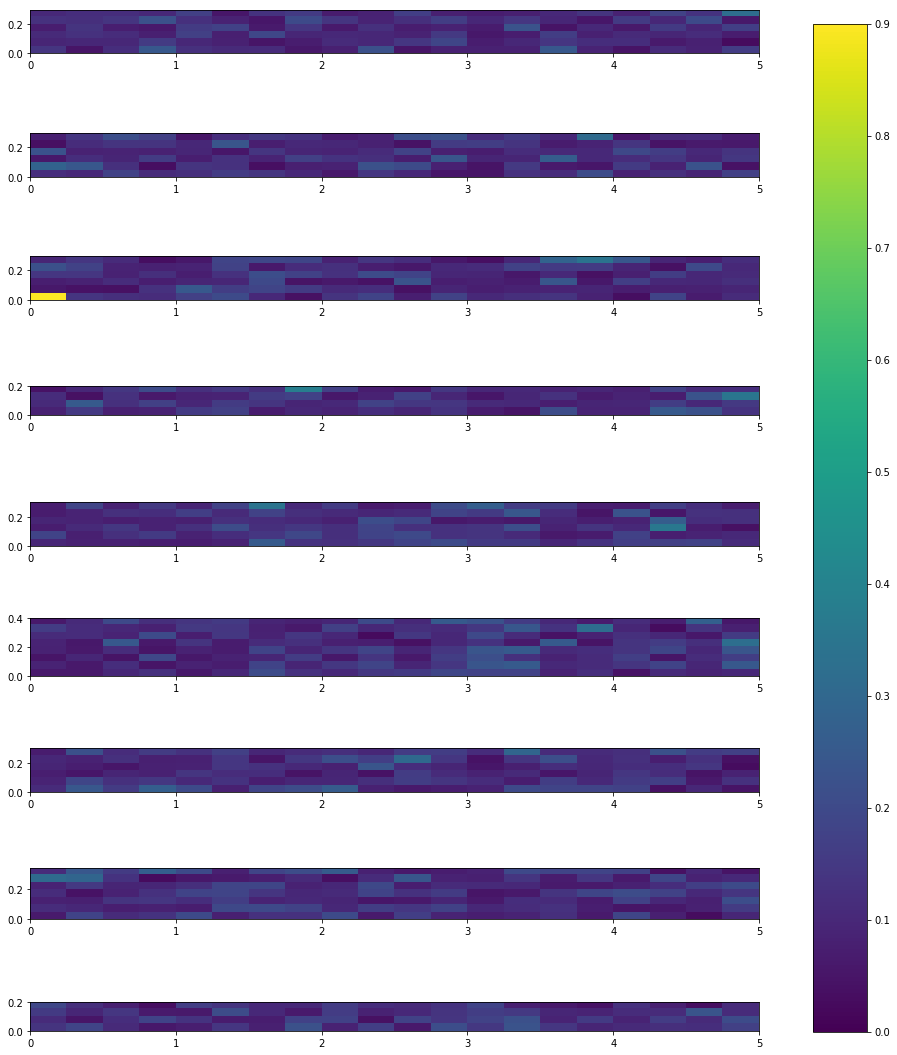

In [637]:
res_ch_w_re_maxtime = np.max(res_ch_w_re,axis=-1)


fig, axes = plt.subplots(nrows=len(striplabels), ncols=1, figsize=(15,20))

s = 0
for ax in axes.flat:
    figheight = len(strips[s])/2
    im = ax.imshow(res_ch_w_re_maxtime[strips[s],:],extent = [0,5,0,0.1*figheight],vmin=0,vmax=0.9)
    
    s = s + 1
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

fig.colorbar(im, cax=cbar_ax)

plt.show()



In [481]:
res_ch_w_re.shape

(52, 20, 80)

In [398]:
feat_trials_red_diff = [feat_trials[i][win_ends[w],ch_idxs_chosen].T - \
                        feat_trials[i][win_starts[w],ch_idxs_chosen].T for i in range(len(feat_trials))]


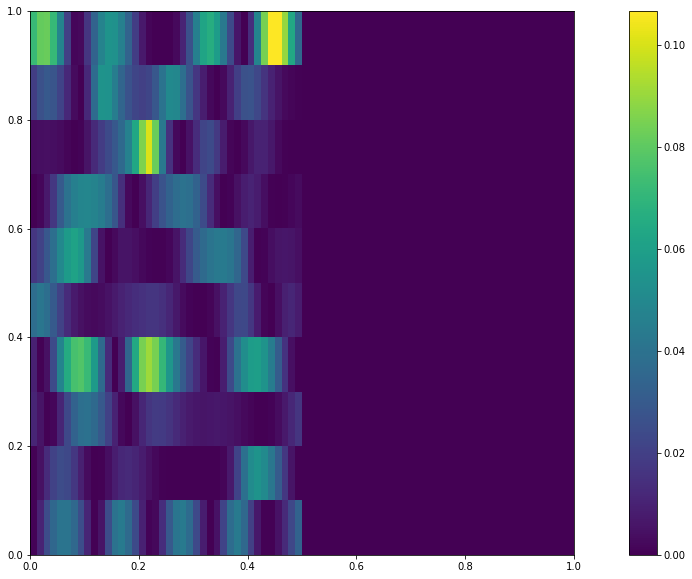

In [399]:
imagesc(res_ch_w[:10,:])
plt.colorbar()

In [ ]:

# compare
print(r2_score(y, y_simple_pred)) # R^2 about 0.53
print(r2_score(y, y_trig_pred))   # R^2 about 0.85


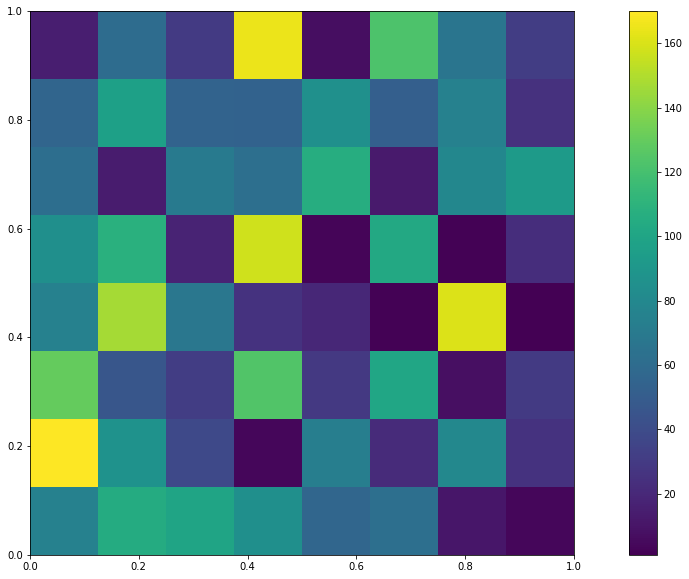

In [142]:
imagesc(cms_allch[0,0,:,:]);
plt.colorbar()

In [123]:
cms_allch[k,:,:,:] = cms

In [108]:
cms_allch.shape

(20, 20, 8, 8)

In [129]:
cms_allch[0]

array([[[ 28.,  51.,  31., ..., 139.,  61.,  27.],
        [ 62., 112.,  49., ...,  48.,  70.,  17.],
        [ 53.,  16.,  87., ...,  19.,  76.,  93.],
        ...,
        [113.,  45.,  34., ..., 125.,   8.,  36.],
        [187.,  80.,  32., ...,  20.,  71.,  33.],
        [ 71.,  99., 106., ...,  70.,   9.,   4.]],

       [[ 49.,  69.,  51., ..., 160.,   7.,  15.],
        [ 86.,   6., 116., ...,   3.,  40.,  10.],
        [ 32.,  86.,  94., ...,   2.,  79.,  20.],
        ...,
        [164.,  16.,  11., ..., 193.,   0.,  40.],
        [ 32., 139.,  90., ...,  48.,   4.,   5.],
        [ 37., 144., 102., ...,  50.,  62.,  11.]],

       [[220., 102.,  45., ...,  25.,   0.,   6.],
        [179.,   2.,  94., ...,  78.,  16.,  56.],
        [ 61.,  59.,  52., ...,   8., 139.,  88.],
        ...,
        [128.,  53.,  58., ...,  20.,  95.,   5.],
        [  1.,  74., 188., ...,  90.,   0., 100.],
        [ 98.,  32., 167., ...,  11.,  74.,  48.]],

       ...,

       [[ 21., 293.,  21

In [ ]:
fig = plt.figure(figsize=(20,5))
rect = fig.patch
plt.gcf().clear()

for p in range(8):
    ax = plt.subplot(1,8,p+1, polar=True)

    angles = [n*3.14/4 for n in range(8)]
    angles += angles[:1]

    cm_to_plot = np.concatenate((cm[p,:],[cm[p,0]]),axis=0)
    cm_to_plot.shape

    plt.plot(angles,cm_to_plot)
    plt.plot([angles[p],angles[p]],[0,200],'m')

    ax.set_rticks([]) 

    ms_into_trial = w*srate//step_div

    win_flash = 128
    if(ms_into_trial > 2048-win_flash)and(ms_into_trial < 2048+win_flash):
        ax.set_facecolor('xkcd:mint green')
    else:
        ax.set_facecolor('white')

if(ms_into_trial > 2048):
    plt.suptitle(str(ms_into_trial-2048)+' ms since GO-signal')
else:
    plt.suptitle(str(2048-ms_into_trial)+' ms to GO-signal')

pylab.savefig(name_prefix+'polar_'+str(w))
plt.gcf().clear()

In [8]:
acc = [np.diag(cms[i])/np.sum(cms[i],axis=1) for i in range(num_w)]

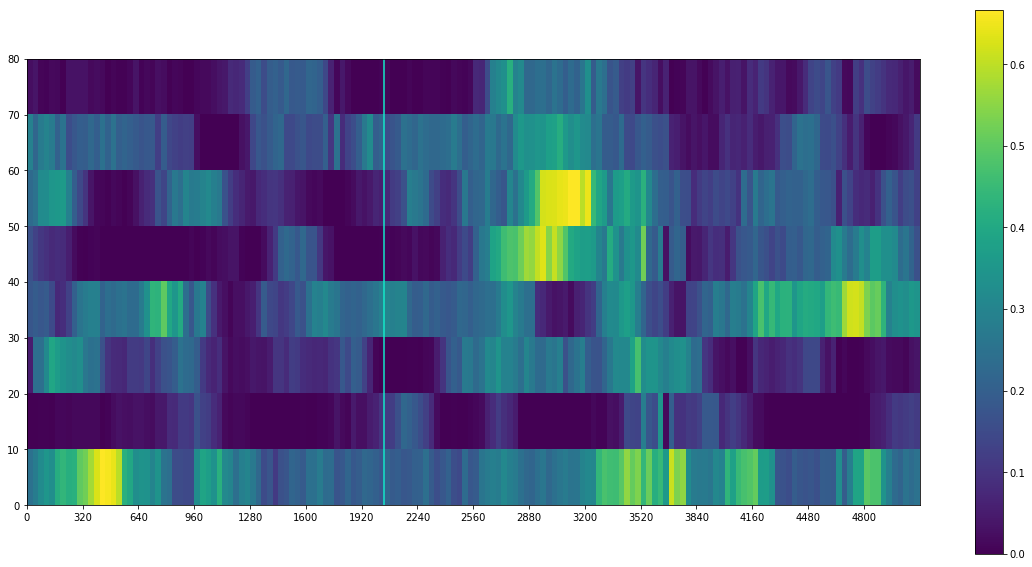

In [52]:
acc_np = np.array(acc)
acc_np.shape

plt.imshow(acc_np.T,extent = [0,160,0,80])
plt.xticks(np.arange(0, 160, step=10), win_starts[::10])
plt.axvline(2048//32,color='xkcd:aqua')
plt.colorbar()